# Lab 6
## [see Report1-2]

In [1]:
import numpy as np

import pandas as pd

import tensorflow as tf

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

df = pd.read_csv("../Data/parkinsons_updrs.csv")

df.test_time = df.test_time.apply(np.abs)
df["day"] = df.test_time.astype(np.int64)
df = df.groupby(["subject#", "day"]).mean()

training_df = df.loc[df.index.get_level_values('subject#') <= 36, df.columns.difference(["day","age","sex","test_time"])]
testing_df = df.loc[df.index.get_level_values('subject#') > 36, df.columns.difference(["day","age","sex","test_time"])]

def standardize (x):
    return (x-x.mean())/x.std()

training_df_st = training_df.apply(standardize)
testing_df_st = testing_df.apply(standardize)
        
tf.set_random_seed(1234)

In [2]:
tf.set_random_seed(1234)

a_0 = np.random.rand(len(training_df_st.columns)-1)
class LR (object):
    
    def __init__ (self, training_df_st, testing_df_st, y_col):

        self.y_col = y_col
        self.x_cols = training_df_st.columns.difference([y_col])
        
        self.train_df = training_df_st
        self.test_df = testing_df_st

        self.y_train = training_df_st[y_col].values
        self.X_train = training_df_st[self.x_cols].values

        self.y_test = testing_df_st[y_col].values
        self.X_test = testing_df_st[self.x_cols].values

        self.e_train = 0.0
        self.e_test = 0.0

        self.a = a_0

    def train (self):        
        pass

class TF_LR_1 (LR):
        
    def run (self):
        
        self.N = self.X_train.shape[0]
        self.F = self.X_train.shape[1]
                
        learning_rate = 1e-4
        
        x = tf.placeholder(tf.float64, [None, self.F])
        t = tf.placeholder(tf.float64, [None, 1])
        
        #--- neural netw structure:
        w1 = tf.Variable(tf.random_normal(shape=[self.F, 1], mean=0.0, stddev=1.0, dtype=tf.float64, name="weights"))
        b1 = tf.Variable(tf.random_normal(shape=[1, 1], mean=0.0, stddev=1.0, dtype=tf.float64, name="biases"))
        y = tf.matmul(x, w1) + b1
        
        #--- optimizer structure
        cost = tf.reduce_sum(tf.squared_difference(y, t, name="objective_function"))
        optim = tf.train.GradientDescentOptimizer(learning_rate, name="GradientDescent")
        optim_op = optim.minimize(cost, var_list=[w1, b1])
        self.cost_history = []
        
        #--- initialize
        init = tf.initialize_all_variables()
        
        #--- run the learning machine
        sess = tf.Session()
        sess.run(init)
        xval = self.X_train
        tval = self.y_train.reshape(self.N, 1)
        for i in range(1000):
            # generate the data
            # train
            train_data = {x: xval, t: tval}
            sess.run(optim_op, feed_dict = train_data)
            c = cost.eval(feed_dict = train_data, session=sess)
            self.cost_history += [c]
        
        #--- print the final results
        print(sess.run(w1), sess.run(b1))
        self.a = sess.run(w1)
        self.yhat_train = y.eval(feed_dict = train_data, session=sess)
        feed_dict = {x: self.X_test}
        self.yhat_test = sess.run(y, feed_dict)


In [3]:
class TF_LR_2 (TF_LR_1):

    def run (self):

        self.N = self.X_train.shape[0]
        self.F = self.X_train.shape[1]
        
        #--- initial settings
        nh1 = 17
        nh2 = 10
        learning_rate = 2e-4
        x = tf.placeholder(tf.float32, [None, self.F])#inputs
        t = tf.placeholder(tf.float32, [None, 1])#desired outputs

        #--- neural netw structure:
        w1 = tf.Variable(tf.random_normal(shape=[self.F, nh1], mean=0.0, stddev=1.0, dtype=tf.float32, name="weights1"))
        b1 = tf.Variable(tf.random_normal(shape=[1, nh1], mean=0.0, stddev=1.0, dtype=tf.float32, name="biases1"))
        a1 = tf.matmul(x, w1) + b1
        z1 = tf.nn.tanh(a1)
        
        w2 = tf.Variable(tf.random_normal([nh1, nh2], mean=0.0, stddev=1.0, dtype=tf.float32, name="weights2"))
        b2 = tf.Variable(tf.random_normal([1, nh2], mean=0.0, stddev=1.0, dtype=tf.float32, name="biases2"))
        a2 = tf.matmul(z1, w2) + b2
        z2 = tf.nn.tanh(a2)
        
        w3 = tf.Variable(tf.random_normal([nh2, 1], mean=0.0, stddev=1.0, dtype=tf.float32, name="weights3"))
        b3 = tf.Variable(tf.random_normal([1, 1], mean=0.0, stddev=1.0, dtype=tf.float32, name="biases3"))
        y = tf.matmul(z2, w3) + b3        

        #--- optimizer structure
        cost = tf.reduce_sum(tf.squared_difference(y, t, name="objective_function"))
        optim = tf.train.GradientDescentOptimizer(learning_rate, name="GradientDescent")
        optim_op = optim.minimize(cost, var_list=[w1, b1, w2, b2, w2, b3])
        self.cost_history = []
        
        #--- initialize
        init = tf.initialize_all_variables()
        
        #--- run the learning machine
        sess = tf.Session()
        sess.run(init)
        for i in range(10000):
            # generate the data
            xval = self.X_train
            tval = self.y_train.reshape(self.N, 1)
            # train
            train_data = {x: xval, t: tval}
            sess.run(optim_op, feed_dict = train_data)
            self.cost_history += [cost.eval(feed_dict = train_data, session=sess)]            
        
        #--- print the final results
        self.w1 = sess.run(w1)
        self.w2 = sess.run(w2)
        self.w3 = sess.run(w3)
        self.yhat_train = y.eval(feed_dict = train_data, session=sess)                
        feed_dict = {x: self.X_test}
        self.yhat_test = sess.run(y, feed_dict)
        

(array([[-0.00615603],
       [-0.00310094],
       [ 0.09255314],
       [-0.13892139],
       [-0.05169815],
       [-0.05826673],
       [ 0.00329486],
       [ 0.09232559],
       [ 0.08685365],
       [-0.02312662],
       [-0.67095592],
       [ 0.50360007],
       [ 0.1941777 ],
       [-1.29759405],
       [-0.10254055],
       [ 1.38140064],
       [ 0.92442913]]), array([[ -2.11507973e-15]]))


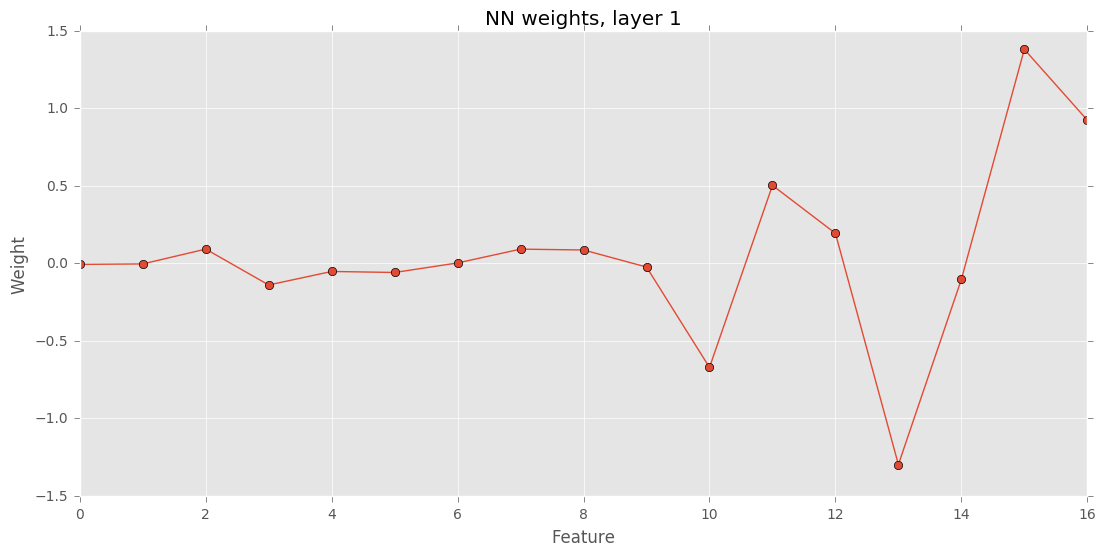

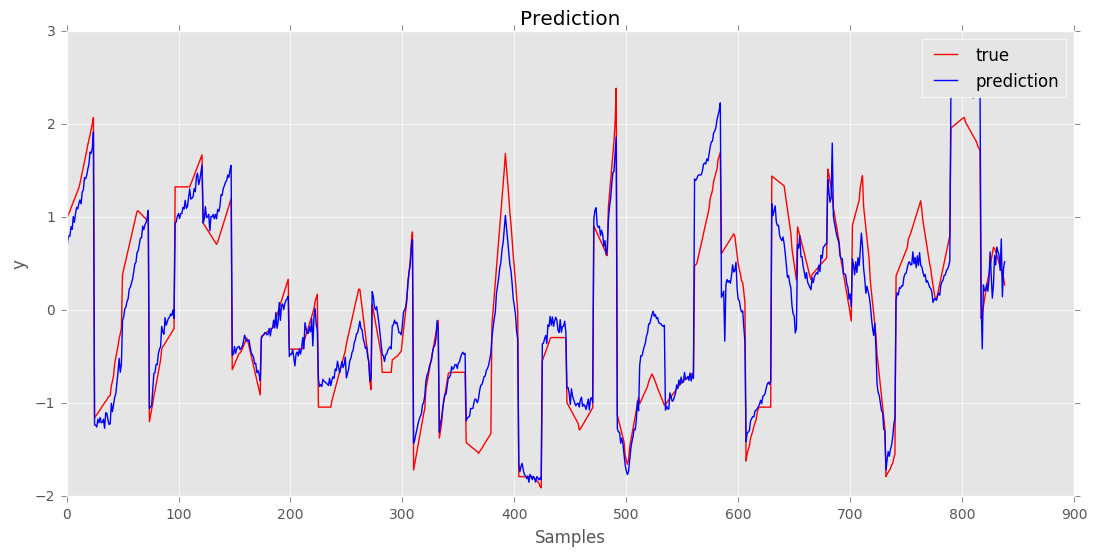

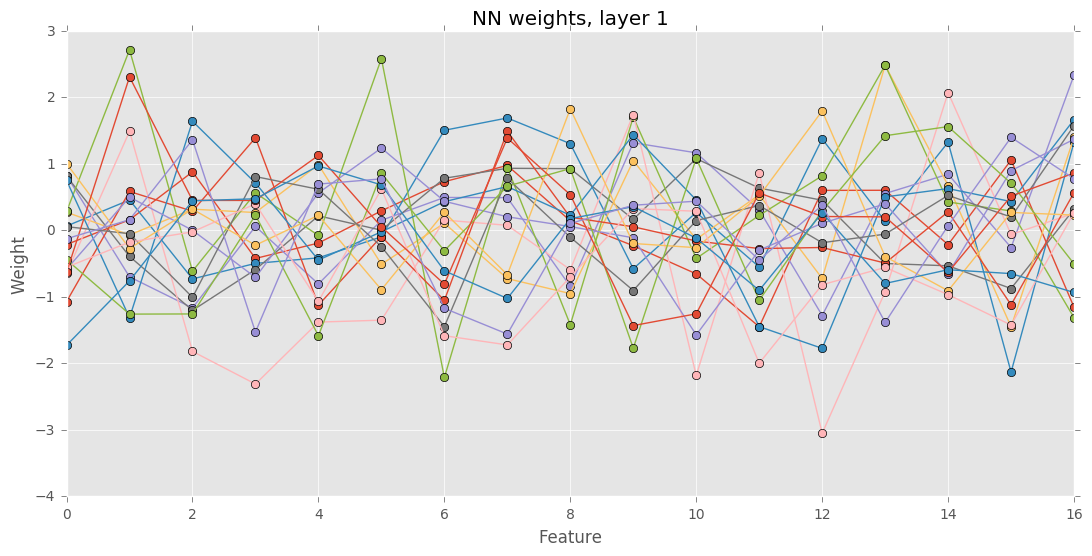

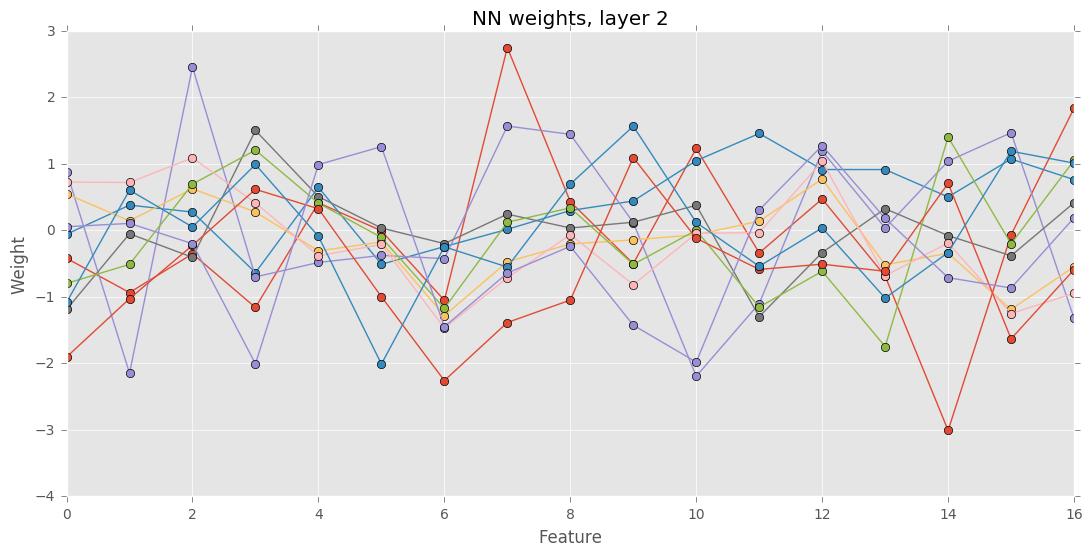

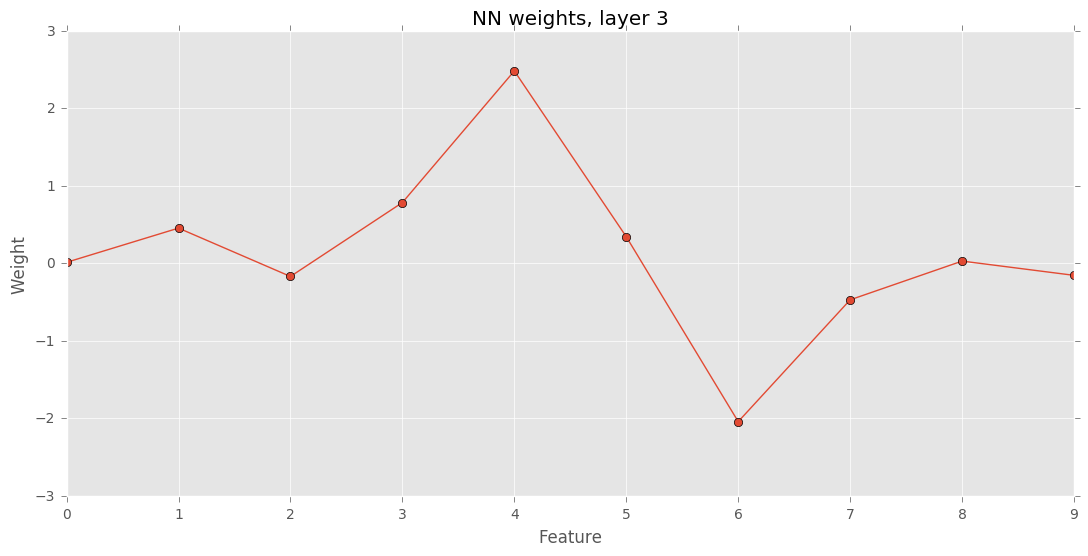

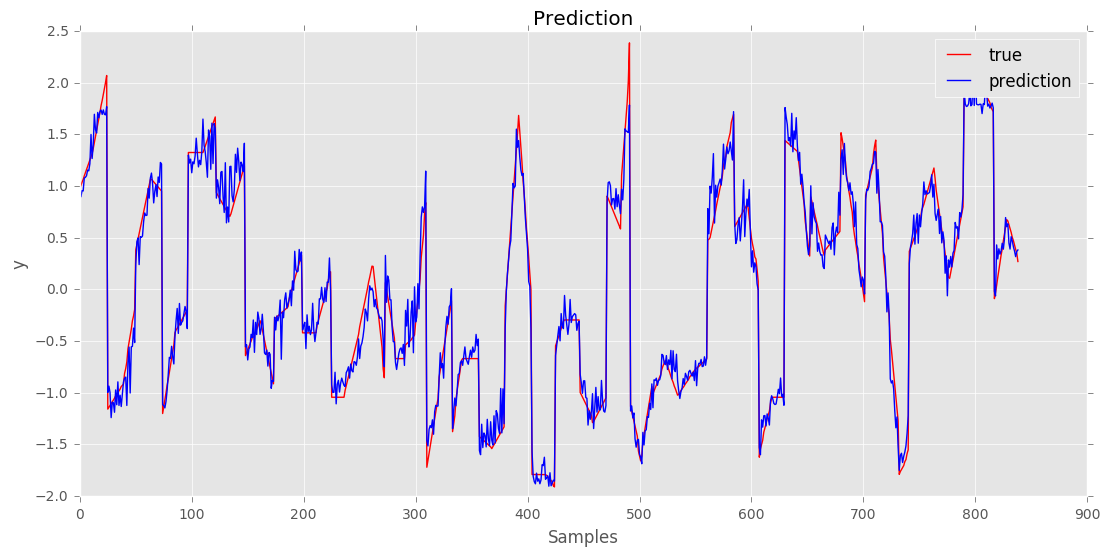

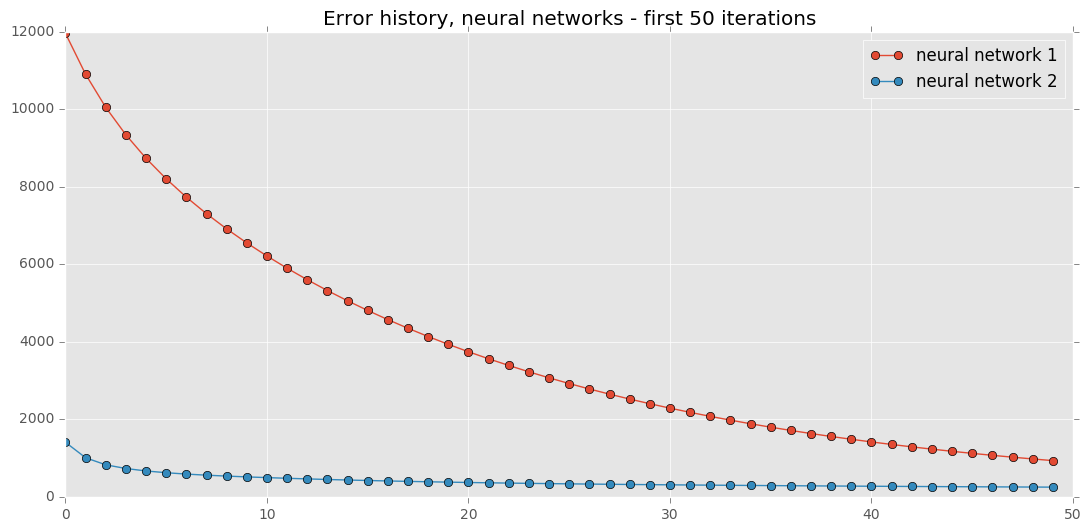

In [4]:
#y_col = "Jitter(%)"
y_col = "motor_UPDRS"
##y_col = "total_UPDRS"
#
tflr1 = TF_LR_1(training_df_st, testing_df_st, y_col)
tflr1.run()

plt.figure(figsize=(13,6))
plt.plot(tflr1.a, marker="o")
plt.title("NN weights, layer 1")
plt.xlabel("Feature")
plt.ylabel("Weight")

plt.figure(figsize=(13,6))
plt.plot(tflr1.y_train,'r', label='true')
plt.plot(tflr1.yhat_train,'b', label='prediction')
plt.legend()
plt.title("Prediction")
plt.xlabel("Samples")
plt.ylabel("y")

tflr2 = TF_LR_2(training_df_st, testing_df_st, y_col)
tflr2.run()

plt.figure(figsize=(13,6))
plt.plot(tflr2.w1, marker="o")
plt.title("NN weights, layer 1")
plt.xlabel("Feature")
plt.ylabel("Weight")

plt.figure(figsize=(13,6))
plt.plot(tflr2.w2, marker="o")
plt.title("NN weights, layer 2")
plt.xlabel("Feature")
plt.ylabel("Weight")

plt.figure(figsize=(13,6))
plt.plot(tflr2.w3, marker="o")
plt.title("NN weights, layer 3")
plt.xlabel("Feature")
plt.ylabel("Weight")

plt.figure(figsize=(13,6))
plt.plot(tflr2.y_train,'r', label='true')
plt.plot(tflr2.yhat_train,'b', label='prediction')
plt.legend()
plt.title("Prediction")
plt.xlabel("Samples")
plt.ylabel("y")

def plot_optimization ():
    
    plt.figure(figsize=(13,6))
    plt.title("Error history, neural networks - first 50 iterations")    
    plt.plot(tflr1.cost_history[:50], marker="o", label="neural network 1")
    plt.plot(tflr2.cost_history[:50], marker="o", label="neural network 2")
    plt.legend()
    
plot_optimization()

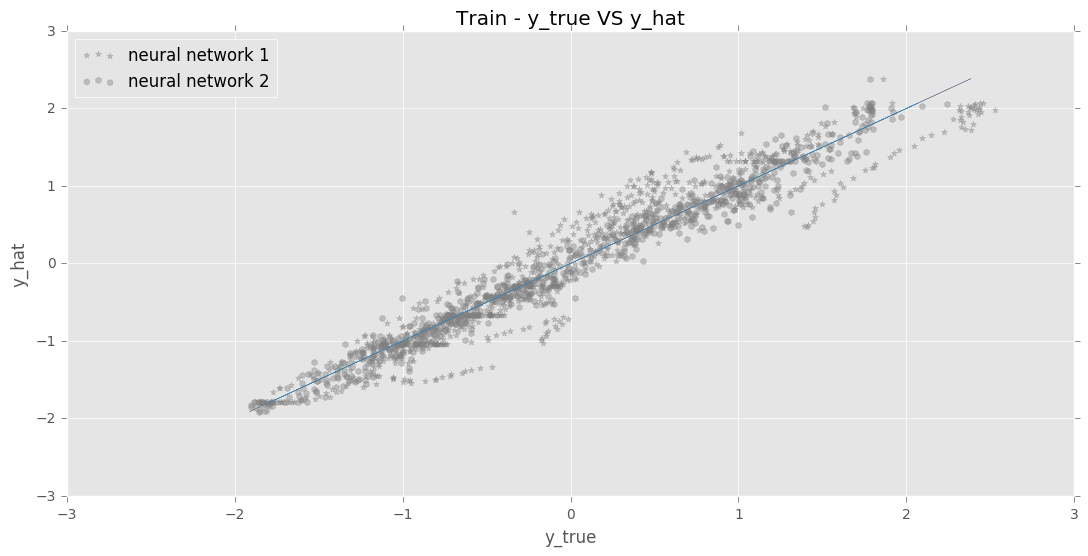

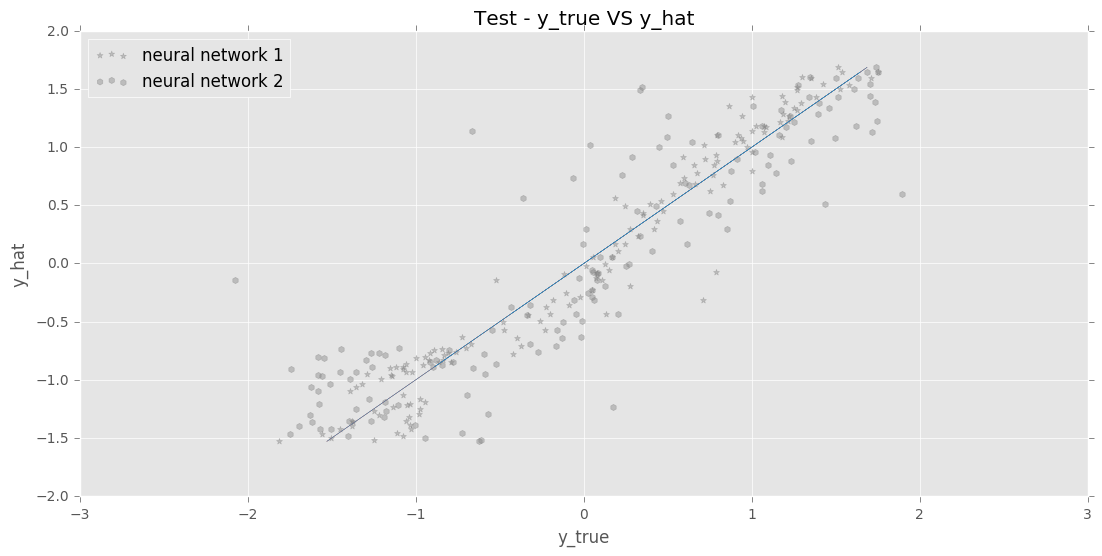

In [5]:
def plot_yhat_vs_ytrue (y_col):
    
    plt.figure(figsize=(13,6))
    plt.scatter(tflr1.yhat_train, tflr1.y_train, label="neural network 1", marker="*", color="grey", alpha=0.4)
    plt.plot(tflr1.y_train, tflr1.y_train, linewidth=0.2)    
    plt.scatter(tflr2.yhat_train, tflr2.y_train, label="neural network 2", marker="h", color="grey", alpha=0.4)
    plt.plot(tflr2.y_train, tflr2.y_train, linewidth=0.2)    
    plt.title("Train - y_true VS y_hat")
    plt.xlabel("y_true")
    plt.ylabel("y_hat")
    plt.legend(loc=2)

    plt.figure(figsize=(13,6))
    plt.scatter(tflr1.yhat_test, tflr1.y_test, label="neural network 1", marker="*", color="grey", alpha=0.4)
    plt.plot(tflr1.y_test, tflr1.y_test, linewidth=0.2)    
    plt.scatter(tflr2.yhat_test, tflr2.y_test, label="neural network 2", marker="h", color="grey", alpha=0.4)
    plt.plot(tflr2.y_test, tflr2.y_test, linewidth=0.2)
    plt.title("Test - y_true VS y_hat")
    plt.xlabel("y_true")
    plt.ylabel("y_hat")
    plt.legend(loc=2)

plot_yhat_vs_ytrue("Jitter(%)")